# Фреймворк PyTorch для разработки искусственных нейронных сетей

## Урок 7. Рекурентные сети для обработки последовательностей

1. Попробуйте обучить нейронную сеть GRU/LSTM для предсказания сентимента сообщений с твитера на примере [dataset](https://www.kaggle.com/datasets/arkhoshghalb/twitter-sentiment-analysis-hatred-speech)

2. Опишите, какой результат вы получили? Что помогло вам улучшить ее точность?

In [1]:
%%capture
# # Скачаем датасет с каггла:
# ! kaggle datasets download arkhoshghalb/twitter-sentiment-analysis-hatred-speech
# ! unzip twitter-sentiment-analysis-hatred-speech.zip

# !pip install stop-words pymorphy2

# # Скачаем библиотеку для лемматизации английских слов:
# ! pip install spacy
# ! spacy download en

Установим необходимые библиотеки:

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from string import punctuation
from stop_words import get_stop_words
from pymorphy2 import MorphAnalyzer
import re
import spacy
from tqdm import tqdm 
tqdm.pandas()
import nltk
from nltk.tokenize import word_tokenize
nltk.download("punkt", quiet=True)
from nltk.probability import FreqDist
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("data/train.csv")

Посмотрим датасет:

In [4]:
df.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [5]:
df['label'].value_counts()

0    29720
1     2242
Name: label, dtype: int64

Распределение лейблов очень неравномерное.

Разобьем датасет, используя стратификацию:

In [6]:
df_train, df_test = train_test_split(df, test_size=0.3, shuffle=True, stratify=df['label'], random_state=42)

In [7]:
df_test['label'].value_counts()

0    8916
1     673
Name: label, dtype: int64

Подготовим функцию для обработки текста с лемматизацией:

In [8]:
sw = set(get_stop_words("english"))
puncts = set(punctuation)
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def preprocess_text(txt):
    txt = str(txt)
    txt = "".join(c for c in txt if c not in puncts)
    txt = txt.lower()
    txt = re.sub("not\s", "not", txt)
    txt = re.sub("dont\s", "dont", txt)
    txt = re.sub("doesnt\s", "doesnt", txt)
    txt = re.sub("didnt\s", "didnt", txt)
    txt = re.sub("havent\s", "havent", txt)
    txt = re.sub("hasnt\s", "hasnt", txt)
    txt = nlp(txt)
    txt = [word.lemma_ for word in txt if word not in sw]
    return " ".join(txt)

In [9]:
df_train['tweet'].iloc[:1].values

array(['happy bihday to my brother man. needed this mixtape like we need boos. have a good one sach   @user '],
      dtype=object)

In [10]:
df_train['tweet'].iloc[:1].apply(preprocess_text).values

array(['happy bihday to my brother man need this mixtape like we need boo have a good one sach    user'],
      dtype=object)

Применим обработку текста с лемматизацией к трейну и тесту:

In [11]:
%%capture
df_train['tweet'] = df_train['tweet'].progress_apply(preprocess_text)
df_test['tweet'] = df_test['tweet'].progress_apply(preprocess_text)

Составим корпус текстов:

In [12]:
train_corpus = " ".join(df_train["tweet"])
train_corpus = train_corpus.lower()

Инициализируем функцию токенизации:

In [13]:
def text_to_sequence(text, maxlen, vocabulary):
    result = []
    tokens = word_tokenize(text.lower())
    tokens_filtered = [word for word in tokens if word.isalnum()]
    for word in tokens_filtered:
        if word in vocabulary:
            result.append(vocabulary[word])

    padding = [0] * (maxlen-len(result))
    return result[-maxlen:] + padding

Инициализируем сеть LSTM:

In [14]:
class LSTMFixedLen(nn.Module) :
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=128, use_last=True):
        super().__init__()
        self.use_last = use_last
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=2, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x = self.embeddings(x)
        x = self.dropout(x)
        lstm_out, ht = self.lstm(x)
       
        if self.use_last:
            last_tensor = lstm_out[:,-1,:]
        else:
            # use mean
            last_tensor = torch.mean(lstm_out[:,:], dim=1)
    
        out = self.linear(last_tensor)
        # print(out.shape)
        return torch.sigmoid(out)

Инициализируем сеть GRU:

In [15]:
class GRUFixedLen(nn.Module) :
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=128, use_last=True):
        super().__init__()
        self.use_last = use_last
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.GRU(embedding_dim, hidden_dim, num_layers=2, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x = self.embeddings(x)
        x = self.dropout(x)
        lstm_out, ht = self.lstm(x)
       
        if self.use_last:
            last_tensor = lstm_out[:,-1,:]
        else:
            # use mean
            last_tensor = torch.mean(lstm_out[:,:], dim=1)
    
        out = self.linear(last_tensor)
        # print(out.shape)
        return torch.sigmoid(out)

Инициализируем класс кастомного датасета:

In [16]:
class DataWrapper(Dataset):
    def __init__(self, data, target, transform=None):
        self.data = torch.from_numpy(data).long()
        self.target = torch.from_numpy(target).long()
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        
        if self.transform:
            x = self.transform(x)
            
        return x, y
    
    def __len__(self):
        return len(self.data)

Инициализируем функцию подготовки загрузчиков:

In [17]:
def get_loaders(max_words=2000, max_len=20):
    tokens = word_tokenize(train_corpus)
    tokens_filtered = [word for word in tokens if word.isalnum()]
    dist = FreqDist(tokens_filtered)
    tokens_filtered_top = [pair[0] for pair in dist.most_common(max_words-1)]
    vocabulary = {v: k for k, v in dict(enumerate(tokens_filtered_top, 1)).items()}

    x_train = np.asarray([text_to_sequence(text, max_len, vocabulary) for text in df_train["tweet"]])
    x_test = np.asarray([text_to_sequence(text, max_len, vocabulary) for text in df_test["tweet"]])

    train_dataset = DataWrapper(x_train, df_train['label'].values)
    train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)

    test_dataset = DataWrapper(x_test, df_test['label'].values)
    test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True)
    return train_loader, test_loader

In [18]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

Инициализируем функцию обучения модели:

In [19]:
def learn_net(model, epochs=20, th=0.5):
    model = model.to(device)
    model.train()

    train_loss_history = []
    test_loss_history = []
    train_f1_history = []
    test_f1_history = []

    for epoch in range(epochs):  
        running_loss, test_loss = 0.0, 0.0
        tp_train, tn_train, fp_train, fn_train = 0.0, 0.0, 0.0, 0.0
        tp_test, tn_test, fp_test, fn_test = 0.0, 0.0, 0.0, 0.0
        pr_train, rec_train = 0.0, 0.0
        pr_test, rec_test = 0.0, 0.0
        f1_score_train, f1_score_test = 0.0, 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)

            # обнуляем градиент
            optimizer.zero_grad()
            outputs = model(inputs)

            loss = criterion(outputs, labels.float().view(-1, 1))
            loss.backward()
            optimizer.step()

            # подсчет ошибки на обучении
            running_loss += loss.item()
            # подсчет метрики на обучении
            pred_labels = torch.squeeze((outputs > th).int())
            tp_train += ((labels == pred_labels) & (labels == 1)).sum().item()
            tn_train += ((labels == pred_labels) & (labels == 0)).sum().item()
            fp_train += ((labels != pred_labels) & (labels == 0)).sum().item()
            fn_train += ((labels != pred_labels) & (labels == 1)).sum().item()
          
        # выводим статистику о процессе обучения
        model.eval()
        pr_train = tp_train / (tp_train + fp_train + .001)
        rec_train = tp_train / (tp_train + fn_train + .001)
        f1_score_train = 2 * pr_train * rec_train / (pr_train + rec_train + .001)
        print(f'Epoch [{epoch + 1}/{epochs}]. ' \
              f'Step [{i + 1}/{len(train_loader)}]. ' \
              f'Loss: {running_loss/(i+1):.3f}. ' \
              f'F1: {f1_score_train:.3f}', end='. ')
      
        train_loss_history.append(running_loss/(i+1))
        train_f1_history.append(f1_score_train)
        running_loss = 0.0
        tp_train, tn_train, fp_train, fn_train = 0.0, 0.0, 0.0, 0.0
        pr_train, rec_train = 0.0, 0.0
        f1_score_train = 0.0

          # выводим статистику на тестовых данных
        for j, data in enumerate(test_loader):
            test_labels = data[1].to(device)
            test_outputs = model(data[0].to(device))

            # подсчет ошибки на тесте
            test_loss += criterion(test_outputs, test_labels.float().view(-1, 1))
            # подсчет метрики на тесте
            pred_test_labels = torch.squeeze((test_outputs > th).int())
            tp_test += ((test_labels == pred_test_labels) & (test_labels == 1)).sum().item()
            tn_test += ((test_labels == pred_test_labels) & (test_labels == 0)).sum().item()
            fp_test += ((test_labels != pred_test_labels) & (test_labels == 0)).sum().item()
            fn_test += ((test_labels != pred_test_labels) & (test_labels == 1)).sum().item()
      
        pr_test = tp_test / (tp_test + fp_test + .001)
        rec_test = tp_test / (tp_test + fn_test + .001)
        f1_score_test = 2 * pr_test * rec_test / (pr_test + rec_test + .001)
        test_loss_history.append(test_loss.item()/(j+1))
        test_f1_history.append(f1_score_test)
        print(f'Test loss: {test_loss/(j+1):.3f}. Test F1: {f1_score_test:.3f}')
        test_loss = 0.0
        tp_test, tn_test, fp_test, fn_test = 0.0, 0.0, 0.0, 0.0
        pr_test, rec_test = 0.0, 0.0
        f1_score_test = 0.0

        model.train()
          
    print('Training is finished!')
    return train_loss_history, test_loss_history, train_f1_history, test_f1_history

Проведем эксперимент, для начала с GRU. Для рекуррентных сетей очень важна длина поступающей последовательности, поэтому начнем с разных длин последовательности:

In [20]:
losses_train = []
losses_test = []
f1_list_train = []
f1_list_test = []
for i in [5, 10, 15, 20]:
    train_loader, test_loader = get_loaders(max_words=2000, max_len=i)
    model = GRUFixedLen(vocab_size=2000)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.BCELoss()
    train_loss_history, test_loss_history, train_f1_history, test_f1_history = learn_net(model)
    losses_train.append(train_loss_history)
    losses_test.append(test_loss_history)
    f1_list_train.append(train_f1_history)
    f1_list_test.append(test_f1_history)

Epoch [1/20]. Step [44/44]. Loss: 0.235. F1: 0.218. Test loss: 0.178. Test F1: 0.428
Epoch [2/20]. Step [44/44]. Loss: 0.160. F1: 0.472. Test loss: 0.165. Test F1: 0.492
Epoch [3/20]. Step [44/44]. Loss: 0.126. F1: 0.608. Test loss: 0.170. Test F1: 0.497
Epoch [4/20]. Step [44/44]. Loss: 0.102. F1: 0.688. Test loss: 0.181. Test F1: 0.543
Epoch [5/20]. Step [44/44]. Loss: 0.081. F1: 0.779. Test loss: 0.194. Test F1: 0.522
Epoch [6/20]. Step [44/44]. Loss: 0.063. F1: 0.820. Test loss: 0.217. Test F1: 0.544
Epoch [7/20]. Step [44/44]. Loss: 0.056. F1: 0.839. Test loss: 0.232. Test F1: 0.542
Epoch [8/20]. Step [44/44]. Loss: 0.046. F1: 0.876. Test loss: 0.247. Test F1: 0.551
Epoch [9/20]. Step [44/44]. Loss: 0.039. F1: 0.900. Test loss: 0.253. Test F1: 0.526
Epoch [10/20]. Step [44/44]. Loss: 0.036. F1: 0.899. Test loss: 0.282. Test F1: 0.538
Epoch [11/20]. Step [44/44]. Loss: 0.032. F1: 0.914. Test loss: 0.303. Test F1: 0.535
Epoch [12/20]. Step [44/44]. Loss: 0.035. F1: 0.912. Test loss:

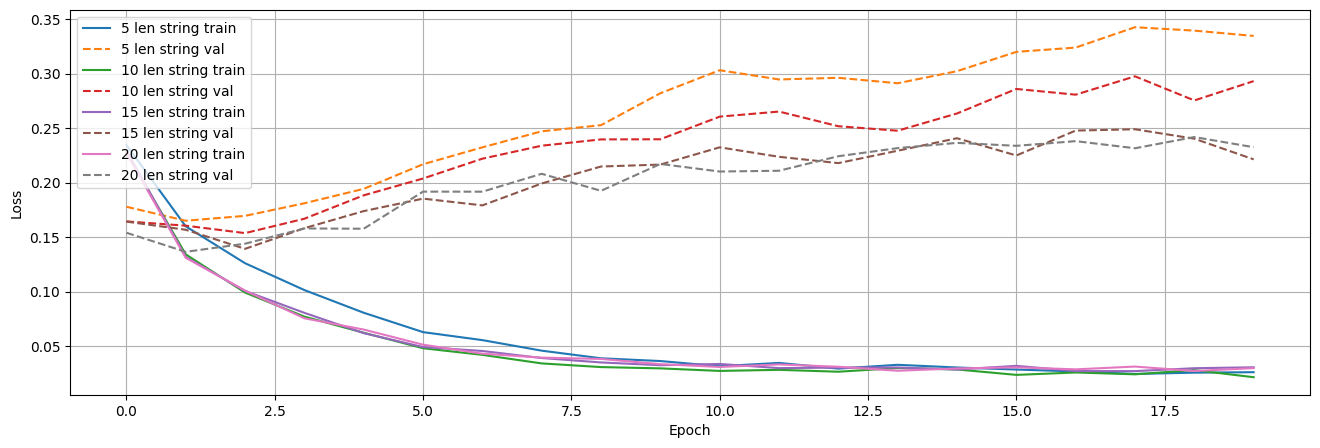

In [21]:
plt.figure(figsize = (16,5))
for i in range(4):
    plt.plot(losses_train[i],'-',label = f'{(i + 1) * 5} len string train')
    plt.plot(losses_test[i],'--',label = f'{(i + 1) * 5} len string val')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.show() 

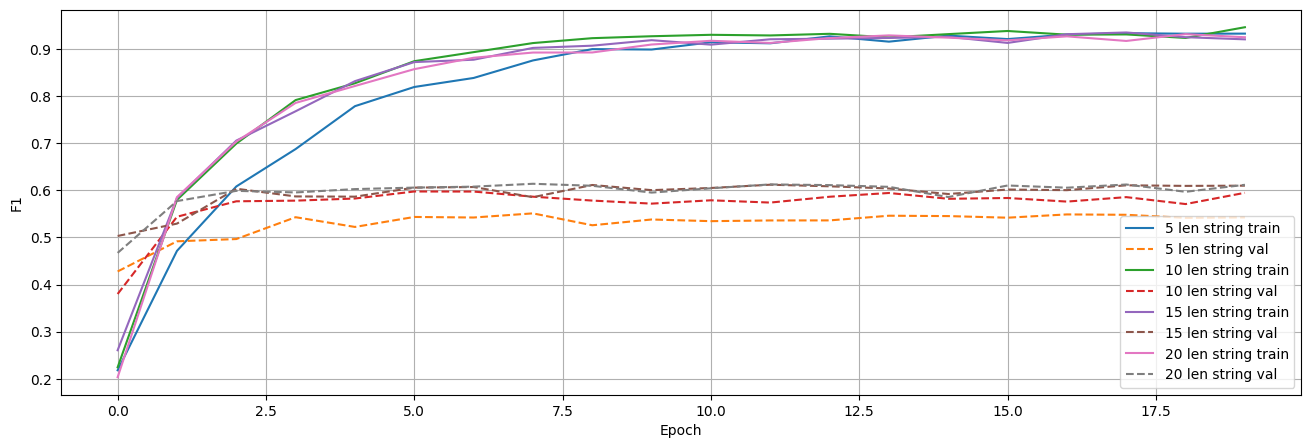

In [22]:
plt.figure(figsize = (16,5))
for i in range(4):
    plt.plot(f1_list_train[i],'-',label = f'{(i + 1) * 5} len string train')
    plt.plot(f1_list_test[i],'--',label = f'{(i + 1) * 5} len string val')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('F1')
plt.grid()
plt.show() 

Модель сильно переобучается, лосс на тесте растет. По метрике лучше себя показывает входная последовательность в 20 токенов. 

Теперь попробуем применить слой дропаут для выходного полносвязного слоя:

In [23]:
class GRUFixedLen2(nn.Module) :
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=128, use_last=True):
        super().__init__()
        self.use_last = use_last
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.GRU(embedding_dim, hidden_dim, num_layers=2, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(0.3)
        self.dropout2 = nn.Dropout(0.3)
        
    def forward(self, x):
        x = self.embeddings(x)
        x = self.dropout(x)
        lstm_out, ht = self.lstm(x)
       
        if self.use_last:
            last_tensor = lstm_out[:,-1,:]
        else:
            # use mean
            last_tensor = torch.mean(lstm_out[:,:], dim=1)
    
        out = self.linear(last_tensor)
        out = self.dropout(out)
        # print(out.shape)
        return torch.sigmoid(out)

Также в эксперименте попробуем 2 варианта - взятие последнего выхода рекуррентного слоя или их усреднение:

In [24]:
losses_train = []
losses_test = []
f1_list_train = []
f1_list_test = []
for i in [True, False]:
    train_loader, test_loader = get_loaders(max_words=2000, max_len=20)
    model = GRUFixedLen2(vocab_size=2000, use_last=i)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.BCELoss()
    train_loss_history, test_loss_history, train_f1_history, test_f1_history = learn_net(model, epochs=40)
    losses_train.append(train_loss_history)
    losses_test.append(test_loss_history)
    f1_list_train.append(train_f1_history)
    f1_list_test.append(test_f1_history)

Epoch [1/40]. Step [44/44]. Loss: 0.378. F1: 0.107. Test loss: 0.183. Test F1: 0.391
Epoch [2/40]. Step [44/44]. Loss: 0.313. F1: 0.418. Test loss: 0.144. Test F1: 0.570
Epoch [3/40]. Step [44/44]. Loss: 0.291. F1: 0.506. Test loss: 0.148. Test F1: 0.557
Epoch [4/40]. Step [44/44]. Loss: 0.277. F1: 0.567. Test loss: 0.139. Test F1: 0.595
Epoch [5/40]. Step [44/44]. Loss: 0.270. F1: 0.596. Test loss: 0.132. Test F1: 0.599
Epoch [6/40]. Step [44/44]. Loss: 0.267. F1: 0.615. Test loss: 0.136. Test F1: 0.620
Epoch [7/40]. Step [44/44]. Loss: 0.261. F1: 0.630. Test loss: 0.133. Test F1: 0.622
Epoch [8/40]. Step [44/44]. Loss: 0.262. F1: 0.634. Test loss: 0.140. Test F1: 0.636
Epoch [9/40]. Step [44/44]. Loss: 0.250. F1: 0.669. Test loss: 0.142. Test F1: 0.618
Epoch [10/40]. Step [44/44]. Loss: 0.250. F1: 0.684. Test loss: 0.142. Test F1: 0.615
Epoch [11/40]. Step [44/44]. Loss: 0.253. F1: 0.691. Test loss: 0.139. Test F1: 0.609
Epoch [12/40]. Step [44/44]. Loss: 0.250. F1: 0.681. Test loss:

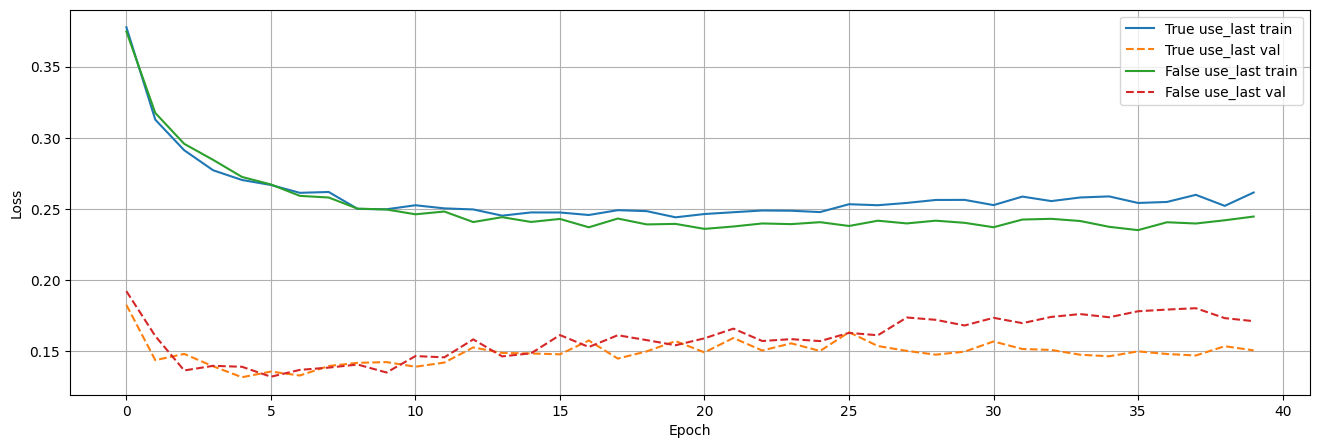

In [25]:
plt.figure(figsize = (16,5))
for i in range(2):
    use_last = 'True'
    if i != 0:
        use_last = 'False'
    plt.plot(losses_train[i],'-',label = f'{use_last} use_last train')
    plt.plot(losses_test[i],'--',label = f'{use_last} use_last val')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.show() 

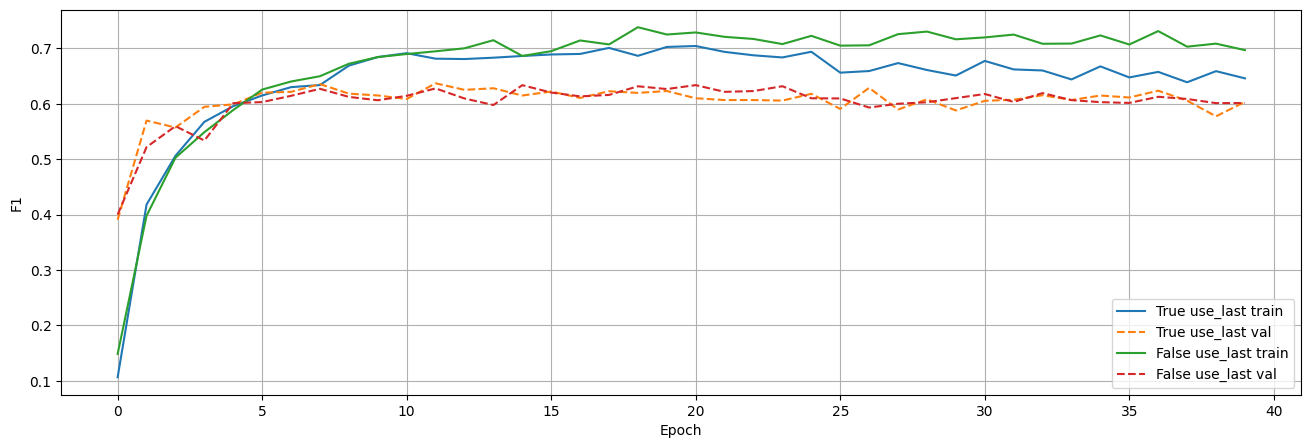

In [26]:
plt.figure(figsize = (16,5))
for i in range(2):
    use_last = 'True'
    if i != 0:
        use_last = 'False'
    plt.plot(f1_list_train[i],'-',label = f'{use_last} use_last train')
    plt.plot(f1_list_test[i],'--',label = f'{use_last} use_last val')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('F1')
plt.grid()
plt.show() 

Дропаут позволил убрать переобучение сети. Также лучше всего себя показывает сеть с усреднением выходов рекуррентного слоя. 

Теперь посмотрим LSTM:

In [27]:
losses_train = []
losses_test = []
f1_list_train = []
f1_list_test = []
for i in [True, False]:
    train_loader, test_loader = get_loaders(max_words=2000, max_len=20)
    model = LSTMFixedLen(vocab_size=2000, use_last=i)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.BCELoss()
    train_loss_history, test_loss_history, train_f1_history, test_f1_history = learn_net(model)
    losses_train.append(train_loss_history)
    losses_test.append(test_loss_history)
    f1_list_train.append(train_f1_history)
    f1_list_test.append(test_f1_history)

Epoch [1/20]. Step [44/44]. Loss: 0.272. F1: 0.000. Test loss: 0.253. Test F1: 0.000
Epoch [2/20]. Step [44/44]. Loss: 0.228. F1: 0.000. Test loss: 0.213. Test F1: 0.000
Epoch [3/20]. Step [44/44]. Loss: 0.182. F1: 0.048. Test loss: 0.182. Test F1: 0.437
Epoch [4/20]. Step [44/44]. Loss: 0.140. F1: 0.535. Test loss: 0.150. Test F1: 0.528
Epoch [5/20]. Step [44/44]. Loss: 0.113. F1: 0.663. Test loss: 0.149. Test F1: 0.601
Epoch [6/20]. Step [44/44]. Loss: 0.096. F1: 0.718. Test loss: 0.149. Test F1: 0.606
Epoch [7/20]. Step [44/44]. Loss: 0.077. F1: 0.782. Test loss: 0.161. Test F1: 0.610
Epoch [8/20]. Step [44/44]. Loss: 0.065. F1: 0.818. Test loss: 0.169. Test F1: 0.622
Epoch [9/20]. Step [44/44]. Loss: 0.063. F1: 0.830. Test loss: 0.173. Test F1: 0.596
Epoch [10/20]. Step [44/44]. Loss: 0.057. F1: 0.840. Test loss: 0.169. Test F1: 0.619
Epoch [11/20]. Step [44/44]. Loss: 0.048. F1: 0.877. Test loss: 0.186. Test F1: 0.630
Epoch [12/20]. Step [44/44]. Loss: 0.041. F1: 0.896. Test loss:

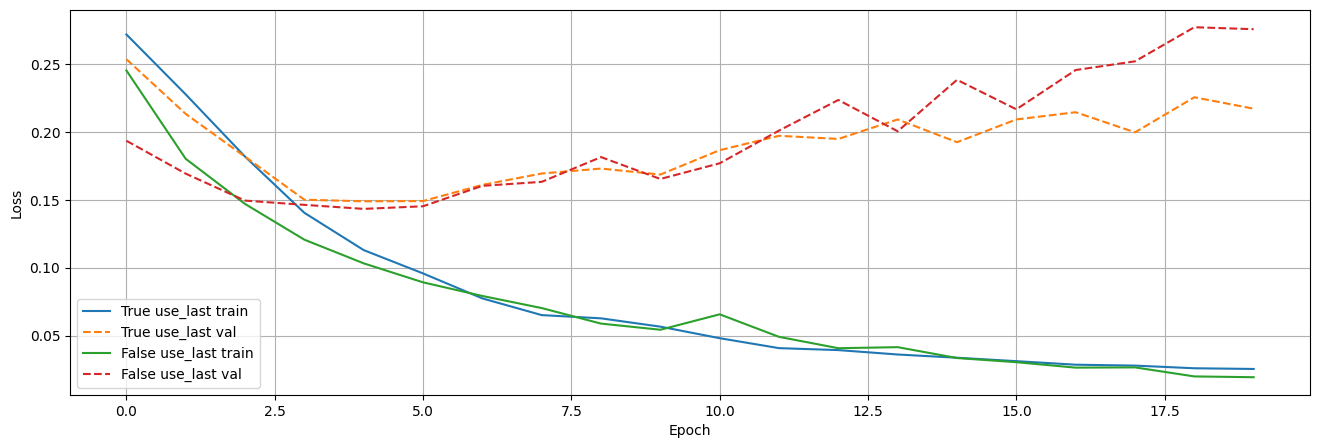

In [28]:
plt.figure(figsize = (16,5))
for i in range(2):
    use_last = 'True'
    if i != 0:
        use_last = 'False'
    plt.plot(losses_train[i],'-',label = f'{use_last} use_last train')
    plt.plot(losses_test[i],'--',label = f'{use_last} use_last val')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.show() 

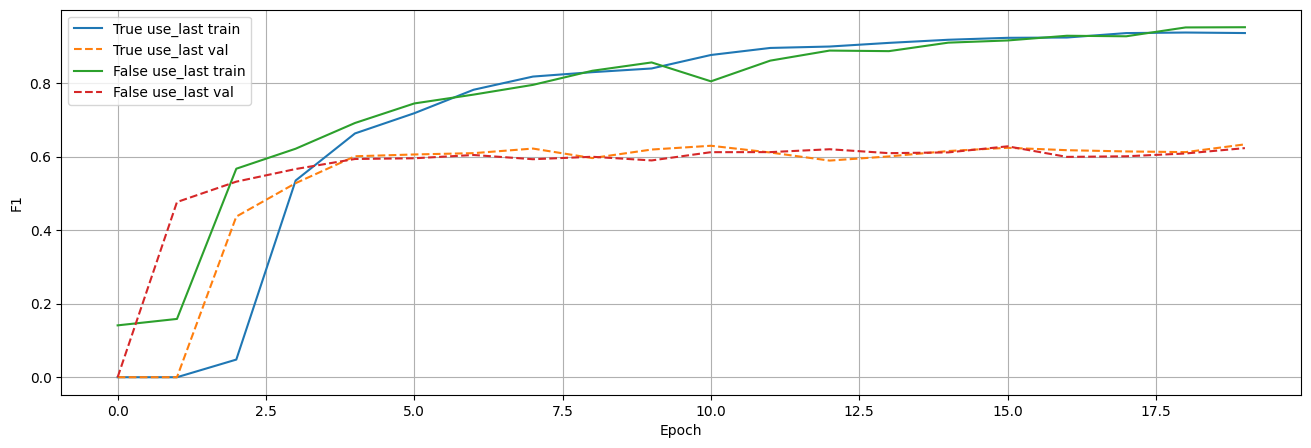

In [29]:
plt.figure(figsize = (16,5))
for i in range(2):
    use_last = 'True'
    if i != 0:
        use_last = 'False'
    plt.plot(f1_list_train[i],'-',label = f'{use_last} use_last train')
    plt.plot(f1_list_test[i],'--',label = f'{use_last} use_last val')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('F1')
plt.grid()
plt.show() 

Также усреднение выходов рекуррентного слоя дает лучший результат. Разнице в метрике по сравнению с GRU особо никакой нет - у GRU был максимум f1 64.9%, у LSTM - 64.5%

Попробуем также изменить длину последовательности:

In [30]:
losses_train = []
losses_test = []
f1_list_train = []
f1_list_test = []
for i in [5, 10, 15, 20]:
    train_loader, test_loader = get_loaders(max_words=2000, max_len=i)
    model = LSTMFixedLen(vocab_size=2000, use_last=False)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.BCELoss()
    train_loss_history, test_loss_history, train_f1_history, test_f1_history = learn_net(model)
    losses_train.append(train_loss_history)
    losses_test.append(test_loss_history)
    f1_list_train.append(train_f1_history)
    f1_list_test.append(test_f1_history)

Epoch [1/20]. Step [44/44]. Loss: 0.261. F1: 0.122. Test loss: 0.199. Test F1: 0.207
Epoch [2/20]. Step [44/44]. Loss: 0.174. F1: 0.369. Test loss: 0.170. Test F1: 0.381
Epoch [3/20]. Step [44/44]. Loss: 0.141. F1: 0.512. Test loss: 0.167. Test F1: 0.482
Epoch [4/20]. Step [44/44]. Loss: 0.117. F1: 0.614. Test loss: 0.179. Test F1: 0.481
Epoch [5/20]. Step [44/44]. Loss: 0.098. F1: 0.707. Test loss: 0.182. Test F1: 0.503
Epoch [6/20]. Step [44/44]. Loss: 0.081. F1: 0.770. Test loss: 0.194. Test F1: 0.515
Epoch [7/20]. Step [44/44]. Loss: 0.065. F1: 0.830. Test loss: 0.225. Test F1: 0.508
Epoch [8/20]. Step [44/44]. Loss: 0.052. F1: 0.862. Test loss: 0.232. Test F1: 0.504
Epoch [9/20]. Step [44/44]. Loss: 0.043. F1: 0.888. Test loss: 0.267. Test F1: 0.522
Epoch [10/20]. Step [44/44]. Loss: 0.039. F1: 0.894. Test loss: 0.257. Test F1: 0.518
Epoch [11/20]. Step [44/44]. Loss: 0.033. F1: 0.916. Test loss: 0.283. Test F1: 0.529
Epoch [12/20]. Step [44/44]. Loss: 0.031. F1: 0.920. Test loss:

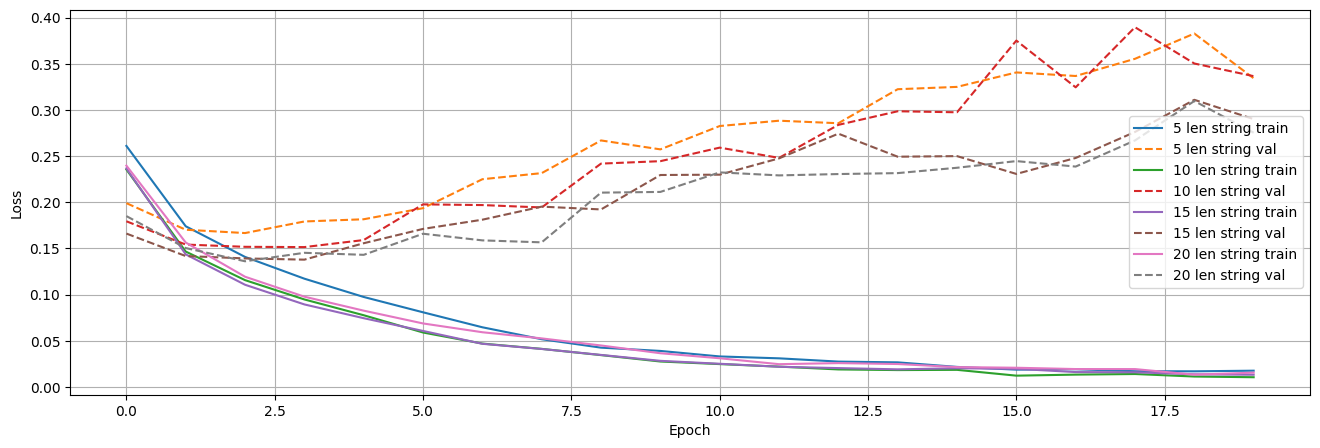

In [31]:
plt.figure(figsize = (16,5))
for i in range(4):
    plt.plot(losses_train[i],'-',label = f'{(i + 1) * 5} len string train')
    plt.plot(losses_test[i],'--',label = f'{(i + 1) * 5} len string val')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.show() 

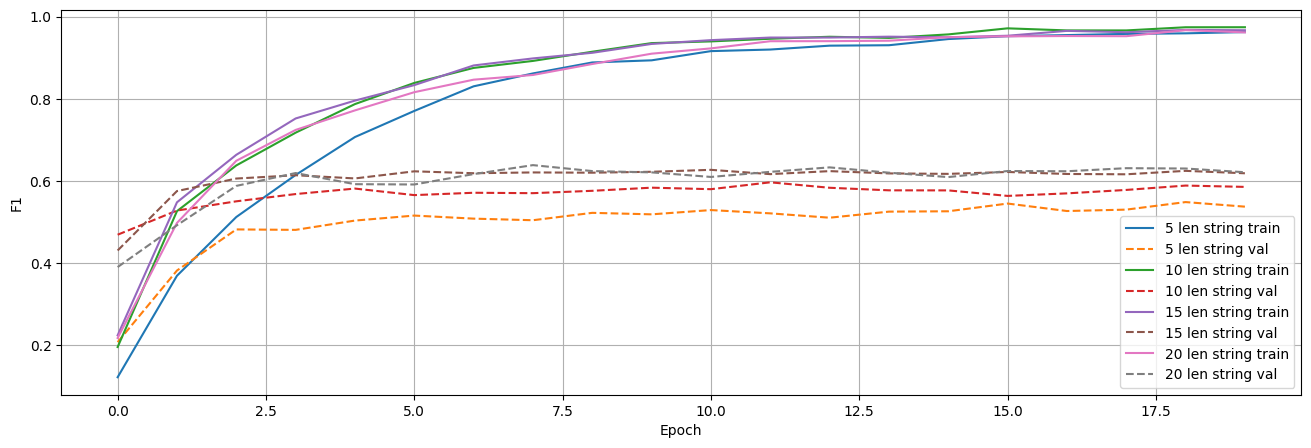

In [32]:
plt.figure(figsize = (16,5))
for i in range(4):
    plt.plot(f1_list_train[i],'-',label = f'{(i + 1) * 5} len string train')
    plt.plot(f1_list_test[i],'--',label = f'{(i + 1) * 5} len string val')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('F1')
plt.grid()
plt.show() 

Лучшую метрику дает последовательность в 15 токенов.

Чтобы снизить переобучение, включим слой дропаут в выходной полносвязный слой:

In [33]:
class LSTMFixedLen2(nn.Module) :
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=128, use_last=True):
        super().__init__()
        self.use_last = use_last
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=2, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(0.4)
        self.dropout2 = nn.Dropout(0.4)
        
    def forward(self, x):
        x = self.embeddings(x)
        x = self.dropout(x)
        lstm_out, ht = self.lstm(x)
       
        if self.use_last:
            last_tensor = lstm_out[:,-1,:]
        else:
            # use mean
            last_tensor = torch.mean(lstm_out[:,:], dim=1)
    
        out = self.linear(last_tensor)
        out = self.dropout(out)
        # print(out.shape)
        return torch.sigmoid(out)

In [34]:
losses_train = []
losses_test = []
f1_list_train = []
f1_list_test = []
for i in [True, False]:
    train_loader, test_loader = get_loaders(max_words=2000, max_len=15)
    model = LSTMFixedLen2(vocab_size=2000, use_last=i)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.BCELoss()
    train_loss_history, test_loss_history, train_f1_history, test_f1_history = learn_net(model, epochs=40)
    losses_train.append(train_loss_history)
    losses_test.append(test_loss_history)
    f1_list_train.append(train_f1_history)
    f1_list_test.append(test_f1_history)

Epoch [1/40]. Step [44/44]. Loss: 0.439. F1: 0.011. Test loss: 0.301. Test F1: 0.063
Epoch [2/40]. Step [44/44]. Loss: 0.412. F1: 0.060. Test loss: 0.207. Test F1: 0.104
Epoch [3/40]. Step [44/44]. Loss: 0.385. F1: 0.196. Test loss: 0.230. Test F1: 0.248
Epoch [4/40]. Step [44/44]. Loss: 0.367. F1: 0.316. Test loss: 0.167. Test F1: 0.499
Epoch [5/40]. Step [44/44]. Loss: 0.360. F1: 0.437. Test loss: 0.171. Test F1: 0.564
Epoch [6/40]. Step [44/44]. Loss: 0.353. F1: 0.440. Test loss: 0.155. Test F1: 0.555
Epoch [7/40]. Step [44/44]. Loss: 0.345. F1: 0.472. Test loss: 0.158. Test F1: 0.588
Epoch [8/40]. Step [44/44]. Loss: 0.342. F1: 0.495. Test loss: 0.153. Test F1: 0.618
Epoch [9/40]. Step [44/44]. Loss: 0.337. F1: 0.519. Test loss: 0.145. Test F1: 0.610
Epoch [10/40]. Step [44/44]. Loss: 0.331. F1: 0.522. Test loss: 0.142. Test F1: 0.600
Epoch [11/40]. Step [44/44]. Loss: 0.331. F1: 0.534. Test loss: 0.147. Test F1: 0.613
Epoch [12/40]. Step [44/44]. Loss: 0.328. F1: 0.562. Test loss:

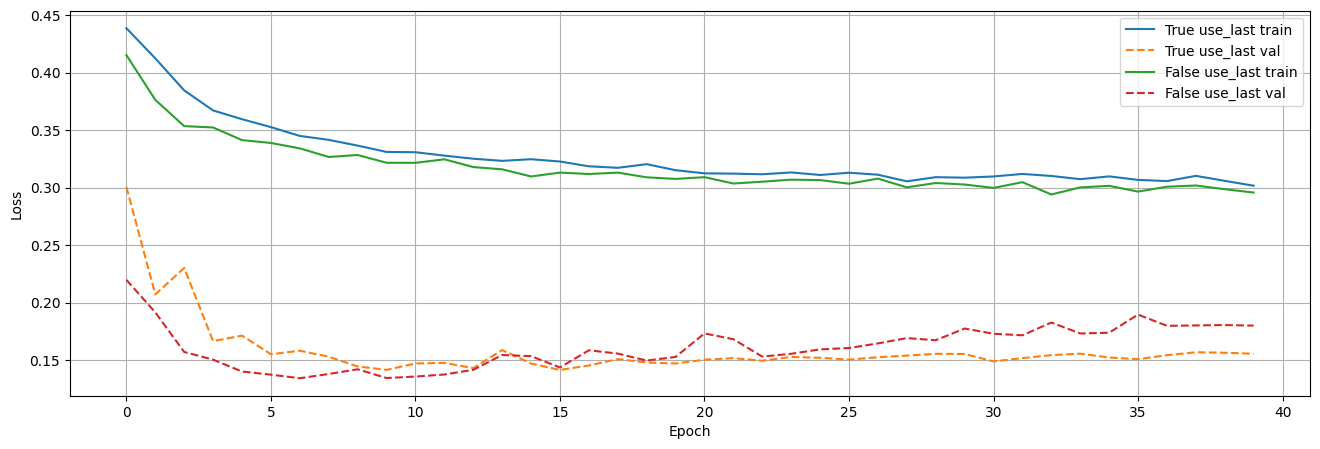

In [35]:
plt.figure(figsize = (16,5))
for i in range(2):
    use_last = 'True'
    if i != 0:
        use_last = 'False'
    plt.plot(losses_train[i],'-',label = f'{use_last} use_last train')
    plt.plot(losses_test[i],'--',label = f'{use_last} use_last val')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.show()

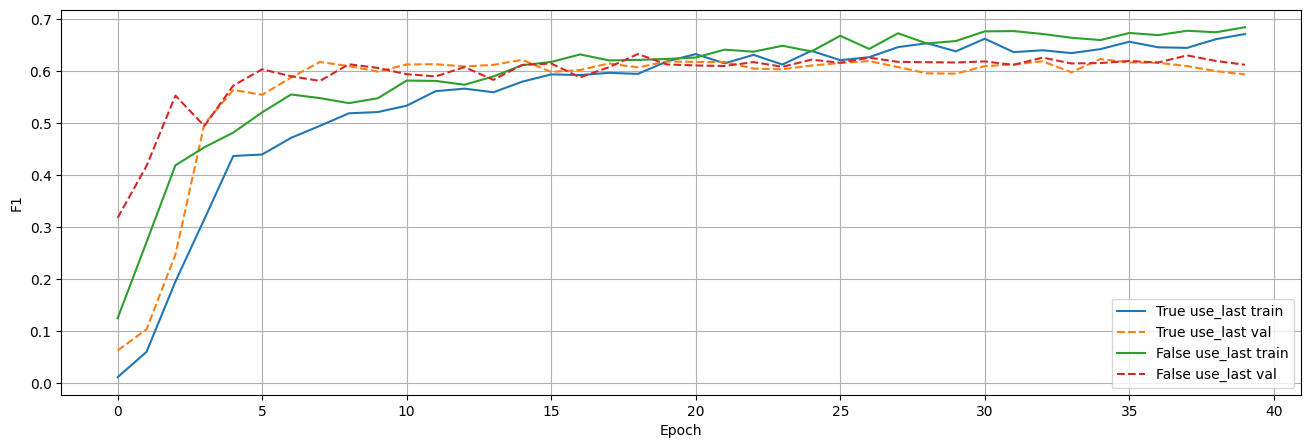

In [36]:
plt.figure(figsize = (16,5))
for i in range(2):
    use_last = 'True'
    if i != 0:
        use_last = 'False'
    plt.plot(f1_list_train[i],'-',label = f'{use_last} use_last train')
    plt.plot(f1_list_test[i],'--',label = f'{use_last} use_last val')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('F1')
plt.grid()
plt.show() 

Удалось полностью убрать переобучение. Усреднение выходов рекуррентного слоя по прежнему лучше. Применение дропаута выходного слоя, как и в случае с GRU, на несколько тысячных снижает метрику на тесте. Здесь максимальная метрика - 64%, без дропаута было 64.5%

**Выводы:**


*   В рекуррентных сетях важна длина последовательности.
*   Для данной задачи GRU дает на несколько тысячных больше по метрике на тесте.


*   Дропаут выходного слоя сокращает переобучение, но метрика на тесте так же немного падает.
*   Также были применены изменения отсечек, но максимум был при 0.5, и разница метрики при измении отсечки была невелика. Поэтому этот анализ не представлен.



